# Введение в искусственные нейронные сети
# Домашнее задание 1. Основы обучения нейронных сетей

### 1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность (число нейронов, число эпох , можно изменять число слоев).

In [1]:
'''
Построение двухслойной нейронный сети для классификации цветков ириса
'''
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [2]:
# преобразование массива в бинарный вид результатов    
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

In [3]:
# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [4]:
def evaluate_accuracy(y_pred, y_true):
    return (1 - np.mean(np.abs(y_true - y_pred))) * 100

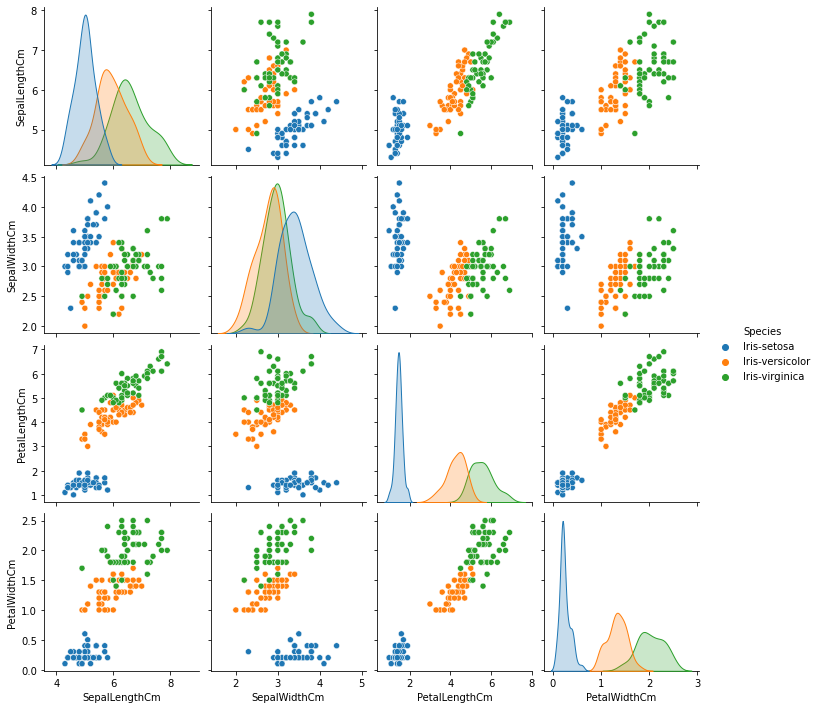

In [5]:
### Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
# print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
#x = normalize(x.as_matrix())
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
#y = y.as_matrix()
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

### Класс нейронной сети

In [61]:
class NeuralNetwork():
    
    def __init__(self, inputs=4, outputs=3, neuron_numb=5, epochs=3000, activation='sigmoid', n_layers=4, learning_rate=0.005):
        self.inputs=inputs # кол-во входов
        self.outputs=outputs # кол-во выходов
        self.neuron_numb=neuron_numb # кол-во нейронов внутренних слоев
        self.epochs=epochs # кол-во эпох
        self.activation=activation # функция активации 'relu' или 'sigmoid'
        self.n_layers=n_layers # кол-во слоев (реализовано для количества слоев >= 2)
        self.learning_rate=learning_rate # скорость обучения
        self.weights=[] # веса
        self.errors=[] # ошибки
        self.layers=[] # слои
        self.current_pred = [] # текущее предсказание
        self.weights_generate()
    
    # сигмоида и ее производная
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def sigmoid_deriv(self, x):
        return (x)*(1 - (x))
    
    # вычисление Relu функции    
    def relu(self, x):
         return x * (x  >  0)
        
    # вычисление производной от Relu функции
    def relu_deriv(self, x):
        return x>0

    # функция генерации весов при инициализации объекта класса
    def weights_generate(self):
        self.weights=[] # веса
        # присваивание случайных весов
        w_start = 2*np.random.random((self.inputs, self.neuron_numb)) - 1 # для входного слоя   - inputs входов, neuron_numb выходов
        w_final = 2*np.random.random((self.neuron_numb, self.outputs)) - 1 # для внутреннего слоя - neuron_numb входов, outputs выходов
        self.weights.append(w_start)
        if self.n_layers > 2:
            for index in range(self.n_layers - 2):
                w = 2*np.random.random((self.neuron_numb, self.neuron_numb)) - 1
                self.weights.append(w)
        self.weights.append(w_final)
    
    # обучение нейронной сети
    def fit(self, X_train, y_train):
        self.errors=[] # ошибки
        # процесс обучения
        for i in range(self.epochs):
            self.layers=[]
            self.layers.append(X_train) # layer0
            # прямое распространение(feed forward)
            next_layer = self.layers[0]

            for index in range(self.n_layers):
                if self.activation == 'sigmoid':
                    next_layer = self.sigmoid(np.dot(next_layer, self.weights[index]))
                elif self.activation == 'relu':
                    next_layer = self.relu(np.dot(next_layer, self.weights[index]))
                self.layers.append(next_layer)

            # обратное распространение(back propagation) с использованием градиентного спуска
            layer_fin_error = y_train - self.layers[-1] # производная функции потерь = производная квадратичных потерь
            if self.activation == 'sigmoid':
                layer_fin_delta = layer_fin_error * self.sigmoid_deriv(self.layers[-1])
            elif self.activation == 'relu':
                layer_fin_delta = layer_fin_error * self.relu_deriv(self.layers[-1])
            previous_layer_delta = layer_fin_delta
            
            for index in range(self.n_layers - 1):
                layer_error = previous_layer_delta.dot(self.weights[-(index + 1)].T)
                if self.activation == 'sigmoid':
                    layer_delta = layer_error * self.sigmoid_deriv(self.layers[-(index + 2)])
                elif self.activation == 'relu':
                    layer_delta = layer_error * self.relu_deriv(self.layers[-(index + 2)])
                self.weights[-(index + 1)] += self.layers[-(index + 2)].T.dot(previous_layer_delta) * self.learning_rate
                previous_layer_delta = layer_delta
            self.weights[0] += self.layers[0].T.dot(previous_layer_delta) * self.learning_rate
            
            error = np.mean(np.abs(layer_fin_error))
            self.errors.append(error)
    
    # предсказание результата
    def predict(self, X_test):
        # прямое распространение(feed forward)
        next_layer = X_test
        for index in range(self.n_layers):
            if self.activation == 'sigmoid':
                next_layer = self.sigmoid(np.dot(next_layer, self.weights[index]))
            elif self.activation == 'relu':
                next_layer = self.relu(np.dot(next_layer, self.weights[index]))
        
        return next_layer
    
    def plot_train_results(self):
        plt.figure(figsize = (16,5))
        plt.plot(self.errors)
        plt.xlabel('Обучение')
        plt.ylabel('Ошибка')
        plt.show() 

        N = 50
        plt.figure(figsize = (16,5))
        plt.plot(self.layers[-1][:N,1], 'r',label = 'Y new')
        plt.plot(y_train[:N,1],'g', label = 'Y train')
        plt.xlabel('№ примера')
        plt.ylabel('выход сети и целевой')
        plt.legend( )
        plt.show() 

        print("Аккуратность нейронной сети " + str(round(evaluate_accuracy(self.layers[-1], y_train),2)) + "%")
        
    def plot_test_results(self, y_pred, y_test):

        N = 50
        plt.figure(figsize = (16,5))
        plt.plot(y_pred[:N,1],'r',label = 'Y new')
        plt.plot(y_test[:N,1],'g', label = 'Y train')
        plt.xlabel('№ примера')
        plt.ylabel('выход сети и целевой')
        plt.legend( )
        plt.show() 

        # метрика модели
        error_t = np.mean(np.abs(y_test - y_pred))
        accuracy_t = (1 - error_t) * 100
        print("Аккуратность нейронной сети на тесте " + str(round(evaluate_accuracy(y_pred, y_test),2)) + "%")

### Проверяем работу на случайных параметрах

In [129]:
nn = NeuralNetwork(neuron_numb=4, epochs=5000, activation='sigmoid', n_layers=3, learning_rate=0.005)
nn.fit(X_train, y_train)

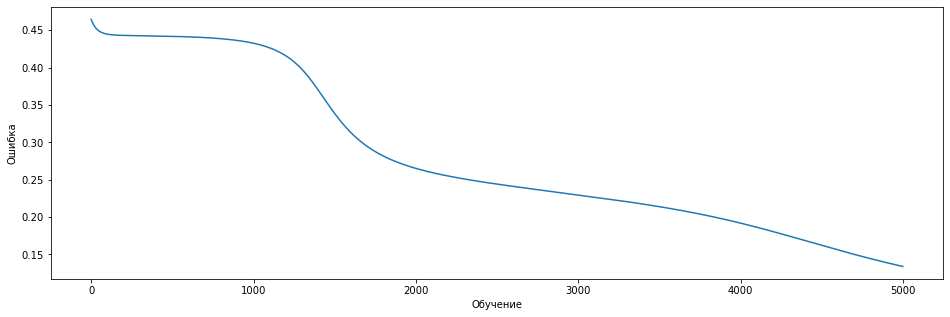

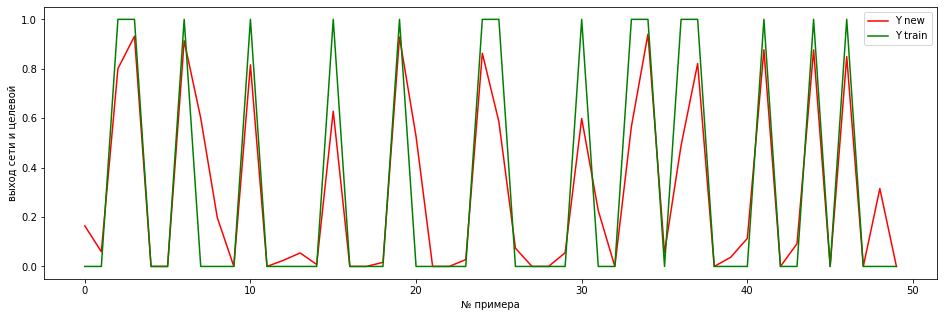

Аккуратность нейронной сети 86.6%


In [130]:
nn.plot_train_results()

In [131]:
res = nn.predict(X_test)

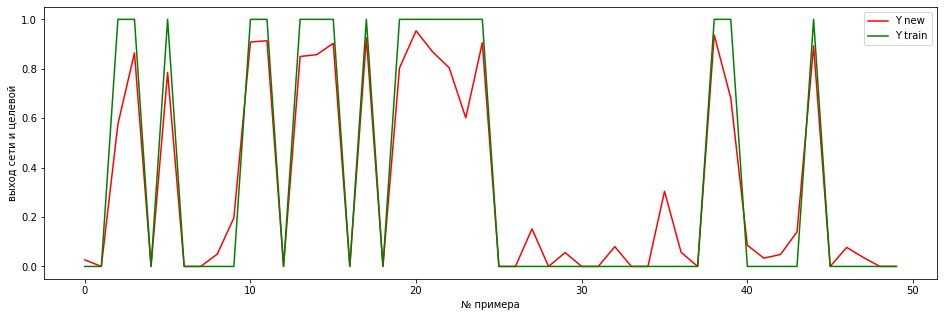

Аккуратность нейронной сети на тесте 88.65%


In [132]:
nn.plot_test_results(res, y_test)

### Проведем подбор параметров

In [133]:
parameters = {'neuron_numb': [3, 5, 7], 
              'epochs': [500, 3000, 10000, 30000], 
              'activation': ['sigmoid', 'relu'], 
              'n_layers': [2, 4, 6], 
              'learning_rate': [0.005, 0.03, 0.1]}

In [134]:
%%time
results = []
for temp_params in product(*parameters.values()):
    temp_parameters = {'neuron_numb': temp_params[0], 
                       'epochs': temp_params[1], 
                       'activation': temp_params[2], 
                       'n_layers': temp_params[3], 
                       'learning_rate': temp_params[4],
                       'accuracy': 0}
    nn = NeuralNetwork(neuron_numb=temp_parameters['neuron_numb'], 
                       epochs=temp_parameters['epochs'], 
                       activation=temp_parameters['activation'], 
                       n_layers=temp_parameters['n_layers'], 
                       learning_rate=temp_parameters['learning_rate'])
    nn.fit(X_train, y_train)
    res = nn.predict(X_test)
    temp_parameters['accuracy'] = evaluate_accuracy(res, y_test)
    results.append(temp_parameters)

Wall time: 3min 51s


### 2. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

In [135]:
pd.set_option('display.max_rows', None)
df = pd.DataFrame(results).sort_values('accuracy', ascending=False)
df

,neuron_numb,epochs,activation,n_layers,learning_rate,accuracy
128,5,30000,sigmoid,2,0.100,99.581326
56,3,30000,sigmoid,2,0.100,99.548868
200,7,30000,sigmoid,2,0.100,99.322460
110,5,10000,sigmoid,2,0.100,99.277151
205,7,30000,sigmoid,6,0.030,99.239695
131,5,30000,sigmoid,4,0.100,99.224740
206,7,30000,sigmoid,6,0.100,99.214054
134,5,30000,sigmoid,6,0.100,99.174830
127,5,30000,sigmoid,2,0.030,99.082371
199,7,30000,sigmoid,2,0.030,99.081573


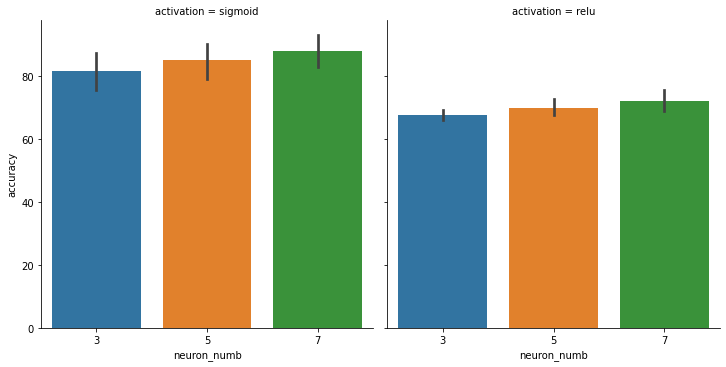

In [151]:
sns.catplot('neuron_numb', 'accuracy', col='activation', data=df, kind='bar')

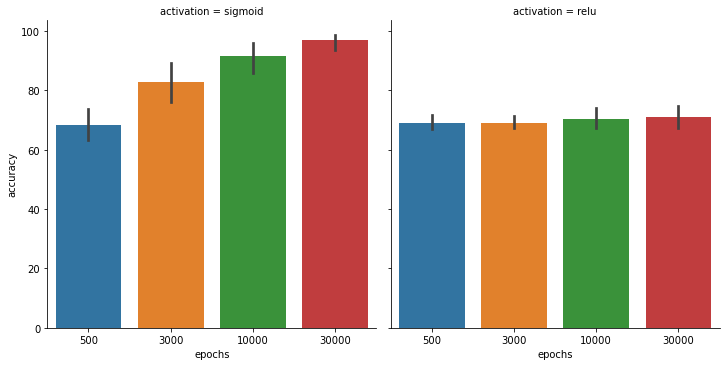

In [152]:
sns.catplot('epochs', 'accuracy', col='activation', data=df, kind='bar')

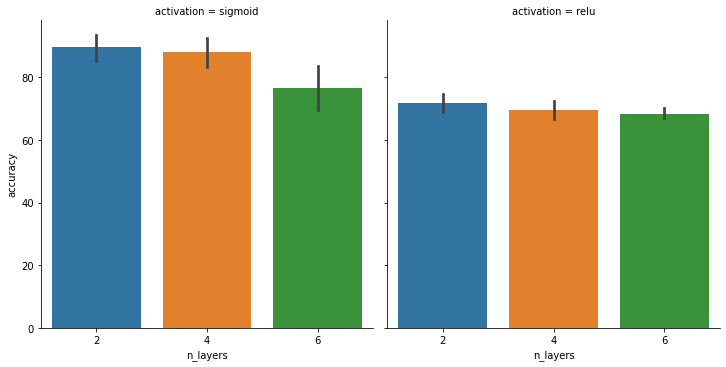

In [153]:
sns.catplot('n_layers', 'accuracy', col='activation', data=df, kind='bar')

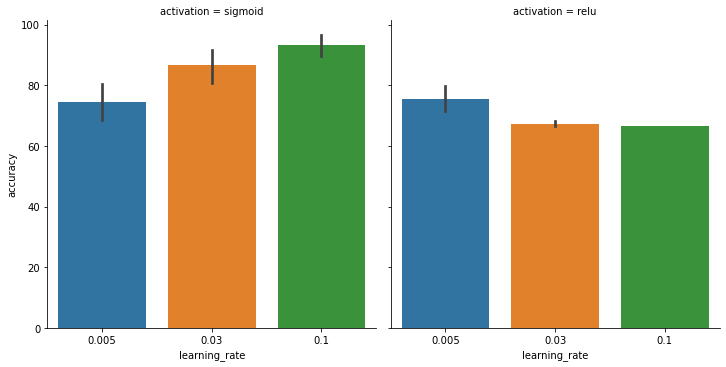

In [154]:
sns.catplot('learning_rate', 'accuracy', col='activation', data=df, kind='bar')

1. Наибольший положительный вклад внесли параметры функции активации (sigmoid), кол-во эпох (чем больше, тем лучше) и скорость обучения (чем выше, чем лучше).

2. Интересно, что самые худшие результаты также у sigmoid - relu середнячок по всем подборам (судя по результатам, требует низкую скорость обучения), т.е. можно сделать вывод, что функция активации sigmoid сильнее зависит от остальных параметров сети и требует более тщательной их настройки.

3. Практически не влияют на результат: количество нейронов и количество слоев (при этом они требуют существенного увеличения числа эпох или скорости обучения для получения допустимых результатов, что логично).